In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import (
    error_lidar_pt_vs_truth_pt,
    plot_photon_map,
    plot_tracklines_overview,
)
from sklearn.metrics import r2_score
import numpy as np
from atl_module.geospatial_utils.raster_interaction import (
    query_raster,
    query_from_lines,
)
import matplotlib.pyplot as plt
from atl_module.bathymetry_extraction.refraction_correction import correct_refr
from atl_module.plotting import set_size

# aggregation functions

In [3]:
# defining some useful aggregation functions

rms_lambda = lambda x: np.sqrt(np.mean(np.square(x)))
mae_lambda = lambda x: np.mean(np.abs(x))

# this is just for by-trackline groupbys
def agg_photon_counts(arr):
    assert np.all(
        arr == arr[0]
    ), "the groupby must be by tracklines with identical values for `n_subsurf_points` and `n_total_points`"
    return arr[0]


# this dictionary can be unpacked into .agg() to create summary table with named columns. can only be used with the bathymetry points GDF since its based on the expected column names
unpackable_error_dict = {
    "RMS Error [m]": pd.NamedAgg(column="error", aggfunc=rms_lambda),
    "MAE [m]": pd.NamedAgg(column="error", aggfunc=mae_lambda),
    "Mean Error [M]": pd.NamedAgg(column="error", aggfunc=np.mean),
    # the total number of points for any grouping is the count of entries in the bathy points gdf
    # the column X, which is the latitude, its used because it always has a valid value
    "n bathy points": pd.NamedAgg(column="X", aggfunc="count"),
    # to get the number of subsurface photons, we can take the mean because it will be the same if we are averaging by site and unique trackline
    # uses a function that raises an error if the points aren't all the same
    # "n photons":pd.NamedAgg(column='n_total_points',aggfunc=agg_photon_counts),
    # "n subsurf photons":pd.NamedAgg(column='n_subsurf_points',aggfunc=agg_photon_counts)
}

# get all AOIs

In [4]:
aoidflist = []
for aoifile in glob("../data/test_sites/*/AOI.gpkg"):
    # get the name of each site
    sitename = aoifile.split("/")[3]
    df = gpd.read_file(aoifile)
    df["site"] = sitename
    aoidflist.append(df)

aoi_combined = pd.concat(aoidflist)

# get all secchi depth points

In [5]:
secchi_pt_list = []
for file in glob("../data/test_sites/*/secchi_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    secchi_pt_list.append(df)

secchi_pt_combined = pd.concat(secchi_pt_list).reset_index(drop=True)

secchi_pt_combined = secchi_pt_combined.assign(
    X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
)

# get all tracklines

In [36]:
# tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/*/tracklines')]

tracklinesdflist = []
for file in glob("../data/test_sites/*/tracklines"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    tracklinesdflist.append(df)

tracklines_combined = pd.concat(tracklinesdflist).reset_index(drop=True)
tracklines_combined = tracklines_combined.assign(
    date=pd.to_datetime(tracklines_combined.date).dt.date
)

tracklines_combined.sort_values('avg_ph_cou')

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,geometry,site
898,processed_ATL03_20190115094052_02740207_005_01,gt1l,274,2019-01-15,strong,5,96.328679,1.000000,0.000000,184.521091,"LINESTRING (-157.83223 21.56362, -157.83208 21...",oahu5
583,processed_ATL03_20200713073941_02740807_005_01,gt2r,274,2020-07-13,weak,34,95.260816,1.147059,0.000000,6218.042512,"LINESTRING (-157.95395 21.27779, -157.95125 21...",oahu1
1200,processed_ATL03_20210507051755_06631101_005_01,gt3r,663,2021-05-07,strong,20,96.302326,1.150000,0.000000,638.312852,"LINESTRING (-158.28003 21.55493, -158.28069 21...",oahu8
510,processed_ATL03_20220531053325_10561501_005_02,gt2l,1056,2022-05-31,strong,216,96.222648,1.310185,0.000000,14332.084721,"LINESTRING (-81.14391 24.61500, -81.15778 24.7...",florida_keys
570,processed_ATL03_20200413115954_02740707_005_01,gt3l,274,2020-04-13,weak,55,95.813700,1.327273,0.000000,6129.874607,"LINESTRING (-157.97985 21.27356, -157.97778 21...",oahu1
...,...,...,...,...,...,...,...,...,...,...,...,...
1063,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,209501,3.120823,2726.849695,0.000000,2851.411856,"LINESTRING (-158.20881 21.57528, -158.21371 21...",oahu7
1159,processed_ATL03_20200606211436_11050701_005_01,gt1l,1105,2020-06-06,strong,850030,3.120823,2727.128385,0.000000,9954.309631,"LINESTRING (-158.17409 21.37328, -158.18971 21...",oahu8
1051,processed_ATL03_20190915220417_12190407_005_01,gt1l,1219,2019-09-15,weak,255324,0.000000,2882.606555,0.000000,3234.898573,"LINESTRING (-158.16393 21.57320, -158.16248 21...",oahu7
1163,processed_ATL03_20200606211436_11050701_005_01,gt3l,1105,2020-06-06,strong,216092,2.836104,3122.430442,0.000000,2382.689088,"LINESTRING (-158.10246 21.31773, -158.10621 21...",oahu8


In [40]:
bathy_pts_df.sort_values('ph_count').ph_count

256338       1
364421       1
222371       1
222372       1
256399       1
          ... 
292973    2213
292974    2213
292975    2213
292965    2213
292971    2213
Name: ph_count, Length: 408565, dtype: int64

# Concatenate all bathymetry points from all sites

In [7]:
dflist = []
for file in glob("../data/test_sites/*/all_bathy_pts.gpkg"):
    # get the name of each site
    sitename = file.split("/")[3]
    df = gpd.read_file(file)
    df["site"] = sitename
    dflist.append(df)

bathy_pts_df = pd.concat(dflist).reset_index(drop=True).dropna()

bathy_pts_df = bathy_pts_df.assign(date=pd.to_datetime(bathy_pts_df.delta_time).dt.date)

# looking into refraction correction

<AxesSubplot:xlabel='p_vec_elev', ylabel='p_vec_az'>

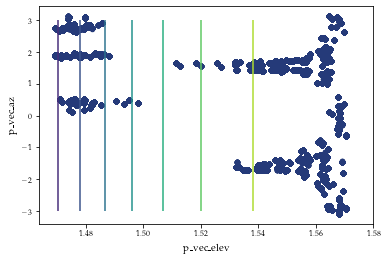

In [8]:
fig, ax = plt.subplots()

az_vecs = np.linspace(-3, 3, 1000)
elev_vecs = np.linspace(1.47, 1.58, 1000)
azgrid, elevgrid = np.meshgrid(az_vecs, elev_vecs)
xcorr, ycorr, zcorr = correct_refr(5, azgrid, elevgrid)

ax.contour(elevgrid, azgrid, zcorr)
bathy_pts_df.plot.scatter(x="p_vec_elev", y="p_vec_az", ax=ax)

In [9]:
el1 = bathy_pts_df.p_vec_elev.max()
az1 = bathy_pts_df.p_vec_az.iloc[bathy_pts_df.p_vec_elev.idxmax()]

In [10]:
correct_refr(10, el1, az1)

(7.236219752462812, 0.001997522355531652, -1.0123863696347617)

## Some stats about all the total batymetry points found

do we see a spike around 2.3 or 4.2 due to ringing?


In [11]:
# set bin edges to encapsulate the location where ringing occurs
binedges = np.arange(-25.05, 0.6, 0.1)
# 2.3 or 4.2 m

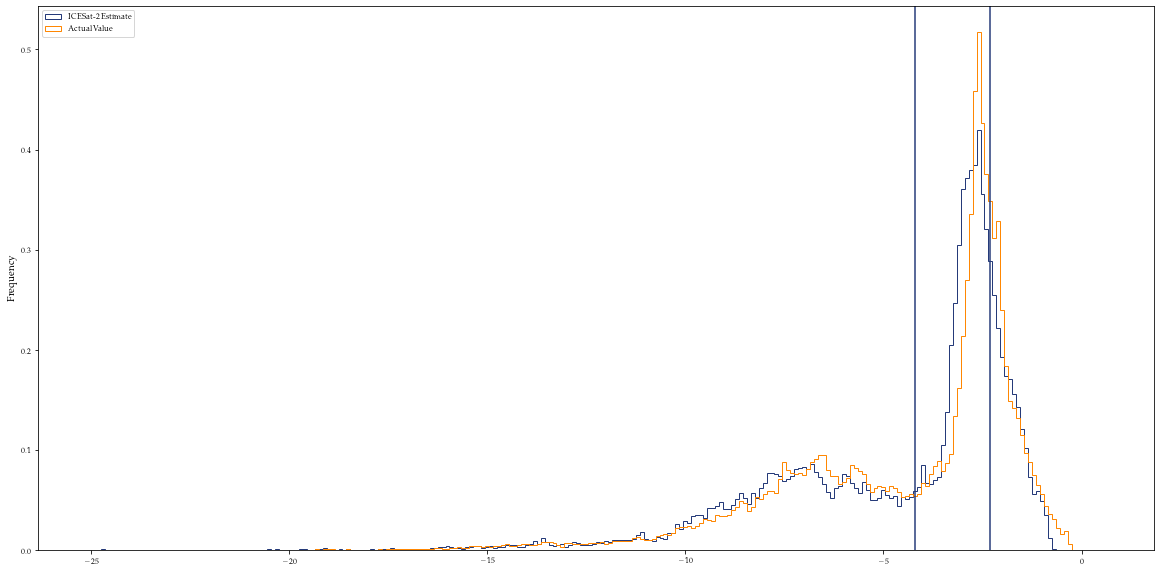

In [12]:
ax = bathy_pts_df.sf_elev_MSL.plot.hist(
    bins=binedges,
    histtype="step",
    density=True,
    label="ICESat-2 Estimate",
    figsize=(20, 10),
)
bathy_pts_df.true_elevation.plot.hist(
    ax=ax, bins=binedges, histtype="step", density=True, label="Actual Value"
)
# ax.set_xlim((-25,0))
ax.axvline(-2.3)
ax.axvline(-4.2)
ax.legend(loc="upper left")

In [13]:
error_by_site = bathy_pts_df.groupby("site").agg(**unpackable_error_dict).round(2)
error_by_site

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,
big_island,0.78,0.51,0.08,4608
charlotteamalie,1.08,0.56,-0.17,14214
florida_keys,0.83,0.32,0.21,261200
oahu1,1.16,0.77,0.54,3207
oahu2,10.60,1.45,1.41,4326
oahu3,1.24,0.46,0.30,18217
oahu4,0.75,0.57,0.41,2544
oahu5,0.73,0.50,0.27,10315
oahu6,2.42,1.76,-1.43,754


based on the graph above we do not see significant deviation from the overall distribution of true bathymetry.

# Sites by Secchi Depth

In [14]:
secchi_pt_combined = secchi_pt_combined.assign(
    gebco_elev=query_raster(
        secchi_pt_combined.assign(
            X=secchi_pt_combined.geometry.x, Y=secchi_pt_combined.geometry.y
        ),
        "../data/GEBCO/GEBCO_2021_sub_ice_topo.nc",
    )
)
# mask out values based on GEBCO elevation
secchi_pt_combined = secchi_pt_combined[secchi_pt_combined.gebco_elev < 0]

In [15]:
zsd_date_beam = (
    secchi_pt_combined.dropna()
    .groupby(["site", secchi_pt_combined.date, "beam"])
    .median()
    .reset_index()
)

Text(0.5, 0.98, '')

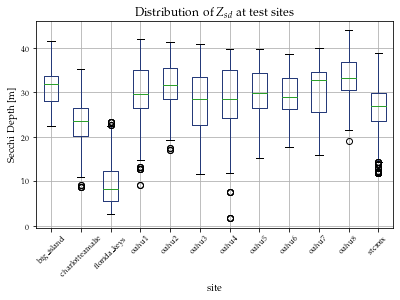

In [16]:
fig, ax = plt.subplots(figsize=set_size())
ax = secchi_pt_combined.boxplot(column="zsd", by="site", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Secchi Depth [m]")
ax.set_title("Distribution of $Z_{sd}$ at test sites")
fig.suptitle(None)

In [17]:
fig.savefig("../document/figures/secchi_by_site_boxplot.pdf")
# fig.savefig('../document/figures/secchi_by_site_boxplot.pgf',backend='pgf')

In [18]:
secchi_pt_combined.groupby("site").median().merge(
    error_by_site, left_index=True, right_index=True
)

,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,RMS Error [m],MAE [m],Mean Error [M],n bathy points
site,,,,,,,,,,,
big_island,31.954956,22.590000,0.031520,31.260000,-155.932170,19.863307,-37.0,0.78,0.51,0.08,4608
charlotteamalie,23.515282,23.920000,0.039698,29.109999,-64.911919,18.345750,-31.0,1.08,0.56,-0.17,14214
florida_keys,8.286758,56.009998,0.095968,74.010002,-80.986446,24.744184,-3.0,0.83,0.32,0.21,261200
oahu1,29.702919,29.519999,0.033219,32.989998,-157.910539,21.276661,-40.0,1.16,0.77,0.54,3207
oahu2,31.586966,28.969999,0.031779,32.270000,-157.679485,21.270529,-47.0,10.60,1.45,1.41,4326
oahu3,28.434975,50.919998,0.034304,59.230000,-157.682220,21.363550,-29.0,1.24,0.46,0.30,18217
oahu4,28.425524,27.139999,0.034313,45.480000,-157.747833,21.474975,-45.0,0.75,0.57,0.41,2544
oahu5,29.843815,25.480000,0.033104,32.930000,-157.917571,21.672136,-34.0,0.73,0.50,0.27,10315
oahu6,28.927444,31.820000,0.033870,32.299999,-157.987923,21.718169,-39.5,2.42,1.76,-1.43,754


The code below makes the table prettier by dropping extraneous columns, renaming the sites to actual names instead of filenames, and adding latex formatted table anmes

In [19]:
# tracklines_by_site = tracklines_combined.groupby(["site"]).median()
tracklines_by_site = (
    secchi_pt_combined.groupby("site")
    .median()
    .merge(error_by_site, left_index=True, right_index=True)
    .drop(columns=["X", "Y", "gebco_elev", "diff_atten", "diff_atten_unc"])
)
namelist = [
    "Big Island",
    "Charlotte Amalie",
    "Florida Keys",
    "Oahu 1",
    "Oahu 2",
    "Oahu 3",
    "Oahu 4",
    "Oahu 5",
    "Oahu 6",
    "Oahu 7",
    "Oahu 8",
    "St. Croix",
]

tracklines_by_site["Site Name"] = namelist
output_table = (
    tracklines_by_site.round(4)
    .set_index("Site Name")
    .rename(
        columns={
            "zsd": "$Zsd_{50}$[m]",
            "sigma_zsd": "$Zsd_{50}$ uncertainty",
            "diff_atten": "Median $Kd_{490}$",
            "diff_atten_unc": "median $Kd_{490}$ uncertainty",
        }
    )
)
output_table

,$Zsd_{50}$[m],$Zsd_{50}$ uncertainty,RMS Error [m],MAE [m],Mean Error [M],n bathy points
Site Name,,,,,,
Big Island,31.9550,22.59,0.78,0.51,0.08,4608
Charlotte Amalie,23.5153,23.92,1.08,0.56,-0.17,14214
Florida Keys,8.2868,56.01,0.83,0.32,0.21,261200
Oahu 1,29.7029,29.52,1.16,0.77,0.54,3207
Oahu 2,31.5870,28.97,10.60,1.45,1.41,4326
Oahu 3,28.4350,50.92,1.24,0.46,0.30,18217
Oahu 4,28.4255,27.14,0.75,0.57,0.41,2544
Oahu 5,29.8438,25.48,0.73,0.50,0.27,10315
Oahu 6,28.9274,31.82,2.42,1.76,-1.43,754


In [20]:
output_table.to_latex(
    "../document/tables/secchi_site.tex",
    float_format="%.2f",
    escape=False,
    label="tab:ocean_color_summary_by_site",
    caption="Secchi Depth and RMSE for each site",
)

NameError: name 'output_table' is not defined

# Analysis of tracklines by site
going to start from scratch

In [21]:
bathy_pts_df.groupby(["site", "date", "beam"]).agg(np.mean)

X          Y    Z_ellip    Z_geoid  \
site       date       beam                                                
big_island 2018-12-05 gt3r -155.948799  19.854967  11.019830  -8.921588   
           2019-09-29 gt3r -156.026809  19.796128  15.458242  -3.125470   
           2020-03-29 gt2r -156.030785  19.792609   5.492370 -12.998258   
           2020-06-02 gt2l -155.932414  19.856520  13.264832  -6.977752   
                      gt2r -155.933253  19.855613  12.965436  -7.267329   
...                                ...        ...        ...        ...   
stcroix    2021-12-15 gt1r  -64.847951  17.669176 -52.092978  -8.489442   
                      gt2l  -64.877354  17.669371 -52.564237  -8.872614   
                      gt2r  -64.877940  17.671653 -51.765971  -8.064654   
           2022-03-15 gt2l  -64.764100  17.672771 -58.796830 -15.271503   
                      gt3l  -64.794097  17.675386 -54.989821 -11.446517   

                            geoid_corr  tide_ocean_corr  geof2m_corr  \
site       date       beam                                             
big_island 2018-12-05 gt3r   19.857108         0.358984     0.084311   
           2019-09-29 gt3r   18.499148        -0.299604     0.084564   
           2020-03-29 gt2r   18.406048        -0.053186     0.084579   
           2020-06-02 gt2l   20.158280         0.129244     0.084304   
                      gt2r   20.148457         0.129247     0.084308   
...                                ...              ...          ...   
stcroix    2021-12-15 gt1r  -43.696786        -0.083813     0.093250   
                      gt2l  -43.784873        -0.083550     0.093249   
                      gt2r  -43.794558        -0.083550     0.093240   
           2022-03-15 gt2l  -43.618563        -0.005797     0.093236   
                      gt3l  -43.636530        -0.005993     0.093226   

                            oc_sig_conf  land_sig_conf  p_vec_az  ...  \
site       date       beam                                        ...   
big_island 2018-12-05 gt3r     1.338983       3.983051  0.228513  ...   
           2019-09-29 gt3r     1.071429       2.785714  3.105283  ...   
           2020-03-29 gt2r     1.093264       0.544041  3.058202  ...   
           2020-06-02 gt2l     2.376106       3.951327  0.160524  ...   
                      gt2r     2.611111       3.870370  0.166057  ...   
...                                 ...            ...       ...  ...   
stcroix    2021-12-15 gt1r     2.551622       3.607670  1.742342  ...   
                      gt2l     2.880562       3.956674  1.491413  ...   
                      gt2r     2.684825       3.856031  1.710539  ...   
           2022-03-15 gt2l     0.408163       0.380952  0.583314  ...   
                      gt3l     1.186100       1.077858  1.318850  ...   

                             kde_val  oc_hconf_perc  n_subsurf_points  \
site       date       beam                                              
big_island 2018-12-05 gt3r  0.159011      95.449276             232.0   
           2019-09-29 gt3r  0.231609      96.049151             197.0   
           2020-03-29 gt2r  0.110753      15.459865            2061.0   
           2020-06-02 gt2l  0.433378      95.968323             622.0   
                      gt2r  0.370803      95.790465             193.0   
...                              ...            ...               ...   
stcroix    2021-12-15 gt1r  0.180389      96.247639             984.0   
                      gt2l  0.131014      96.336958            2128.0   
                      gt2r  0.131747      96.163232             653.0   
           2022-03-15 gt2l  0.106341      51.849537            2145.0   
                      gt3l  0.116321      55.786161            5476.0   

                            n_total_points    easting_raw  northing_raw  \
site       date       beam                                                
big_island 2018-12-05 gt3r          4244.0  191153.114355  2.198133e+06   

In [22]:
error_by_transect = bathy_pts_df.groupby(["site", "date", "beam"]).agg(
    **unpackable_error_dict
)
error_by_transect

RMS Error [m]   MAE [m]  Mean Error [M]  \
site       date       beam                                            
big_island 2018-12-05 gt3r       0.677487  0.593445        0.511916   
           2019-09-29 gt3r       0.794395  0.731832       -0.731832   
           2020-03-29 gt2r       0.450566  0.405324        0.397758   
           2020-06-02 gt2l       0.479867  0.415288        0.390369   
                      gt2r       0.570529  0.431429        0.408422   
...                                   ...       ...             ...   
stcroix    2021-12-15 gt1r       1.729840  1.318498       -1.088719   
                      gt2l       0.657330  0.432050       -0.171566   
                      gt2r       0.781079  0.526942       -0.092972   
           2022-03-15 gt2l       0.993448  0.959139        0.959139   
                      gt3l       0.366838  0.294623       -0.177783   

                            n bathy points  
site       date       beam                  
big_island 2018-12-05 gt3r              59  
           2019-09-29 gt3r              42  
           2020-03-29 gt2r             193  
           2020-06-02 gt2l             226  
                      gt2r              54  
...                                    ...  
stcroix    2021-12-15 gt1r             339  
                      gt2l             854  
                      gt2r             257  
           2022-03-15 gt2l             147  
                      gt3l            2633  

[485 rows x 4 columns]

In [48]:
final_trackline_summary = tracklines_combined.merge(
    error_by_transect, on=["site", "date", "beam"], how="left"
).replace({"n bathy points": np.NaN}, value=0)

final_trackline_summary['ph_per_m']=final_trackline_summary.n_photons/final_trackline_summary['length']

In [49]:
bathy_pts_df.groupby("beamtype").agg(**unpackable_error_dict)

,RMS Error [m],MAE [m],Mean Error [M],n bathy points
beamtype,,,,
strong,0.837542,0.352188,0.167985,354302
weak,3.069375,0.472500,0.135963,54263


In [62]:
final_trackline_summary.groupby(
    final_trackline_summary["n bathy points"]==0
).mean()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n bathy points,,,,,,,,,,
False,48522.412371,83.756101,120.921801,0.006590,12928.917558,1.054246,0.905157,0.24558,842.402062,3.829822
True,75789.487097,48.863845,311.856018,0.004785,8534.659344,NaN,NaN,NaN,0.000000,9.664251


In [60]:
final_trackline_summary

,file,beam,rgt,date,beam_type,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,geometry,site,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
0,processed_ATL03_20181205112951_10360107_005_01,gt1l,1036,2018-12-05,weak,891,95.355358,21.058361,0.002720,1224.413885,"LINESTRING (-155.88434 19.91484, -155.88390 19...",big_island,NaN,NaN,NaN,0.0,0.727695
1,processed_ATL03_20181205112951_10360107_005_01,gt1r,1036,2018-12-05,strong,4481,95.570851,79.936621,0.000000,1474.090683,"LINESTRING (-155.88521 19.91326, -155.88467 19...",big_island,NaN,NaN,NaN,0.0,3.039840
2,processed_ATL03_20181205112951_10360107_005_01,gt2l,1036,2018-12-05,weak,1848,95.192996,7.169372,0.000000,6108.814911,"LINESTRING (-155.91730 19.85597, -155.91512 19...",big_island,NaN,NaN,NaN,0.0,0.302514
3,processed_ATL03_20181205112951_10360107_005_01,gt2r,1036,2018-12-05,strong,6032,95.392791,22.174403,0.000000,6172.008808,"LINESTRING (-155.91815 19.85428, -155.91596 19...",big_island,NaN,NaN,NaN,0.0,0.977316
4,processed_ATL03_20181205112951_10360107_005_01,gt3l,1036,2018-12-05,weak,964,95.234359,9.185685,NaN,2348.510306,"LINESTRING (-155.94826 19.84765, -155.94743 19...",big_island,NaN,NaN,NaN,0.0,0.410473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,processed_ATL03_20220315201713_12761407_005_01,gt1r,1276,2022-03-15,weak,48147,2.183704,128.155524,0.000078,18924.447299,"LINESTRING (-64.73909 17.62984, -64.72144 17.7...",stcroix,NaN,NaN,NaN,0.0,2.544169
1411,processed_ATL03_20220315201713_12761407_005_01,gt2l,1276,2022-03-15,strong,315773,51.849537,548.077090,0.003100,20842.088629,"LINESTRING (-64.76858 17.62954, -64.74916 17.8...",stcroix,0.993448,0.959139,0.959139,147.0,15.150737
1412,processed_ATL03_20220315201713_12761407_005_01,gt2r,1276,2022-03-15,weak,117079,4.900382,242.992484,0.013580,20306.917716,"LINESTRING (-64.76942 17.62944, -64.75051 17.8...",stcroix,NaN,NaN,NaN,0.0,5.765474
1413,processed_ATL03_20220315201713_12761407_005_01,gt3l,1276,2022-03-15,strong,380147,55.786161,763.082147,0.000112,20880.586849,"LINESTRING (-64.79888 17.62915, -64.77940 17.8...",stcroix,0.366838,0.294623,-0.177783,2633.0,18.205762


<AxesSubplot:xlabel='avg_ph_cou', ylabel='RMS Error [m]'>

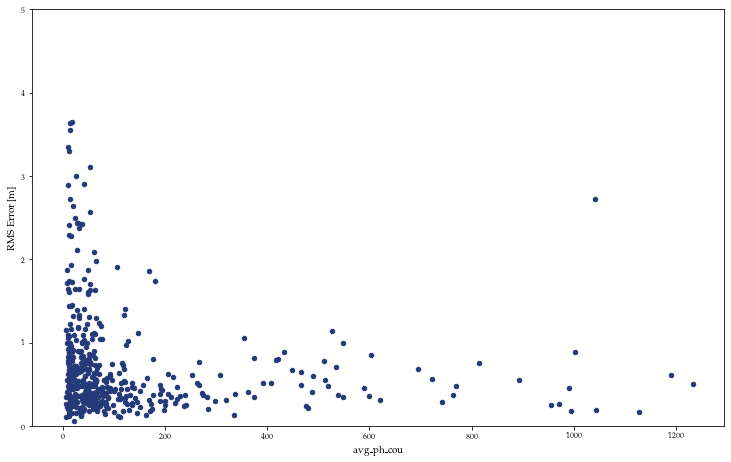

In [51]:
final_trackline_summary.plot.scatter(y='RMS Error [m]',x='avg_ph_cou',figsize=set_size(fraction=2),ylim=(0,5))

<AxesSubplot:xlabel='avg_ph_cou', ylabel='n bathy points'>

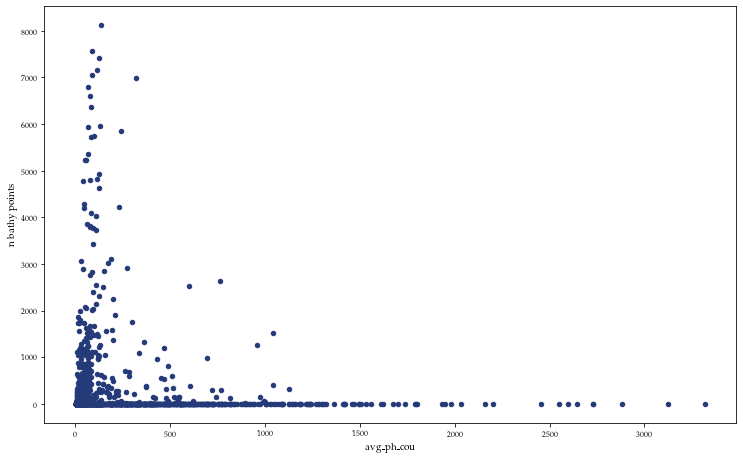

In [52]:
final_trackline_summary.plot.scatter(y='n bathy points',x='avg_ph_cou',figsize=set_size(fraction=2))

<AxesSubplot:xlabel='ph_per_m', ylabel='n bathy points'>

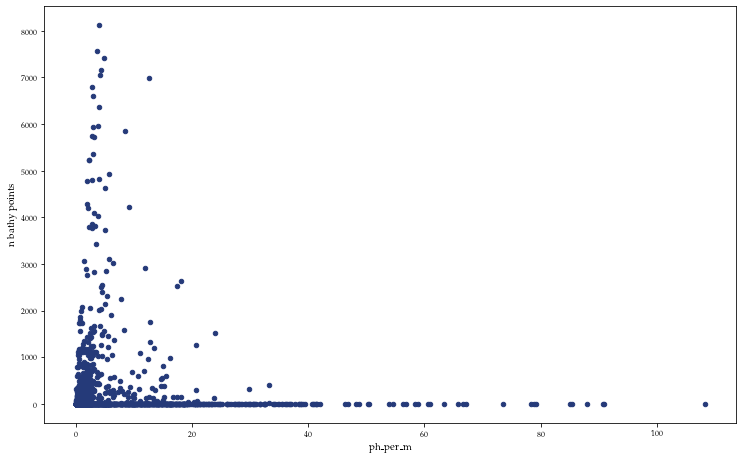

In [55]:
final_trackline_summary.plot.scatter(y='n bathy points',x='ph_per_m',figsize=set_size(fraction=2))

<AxesSubplot:xlabel='p_hconf', ylabel='n bathy points'>

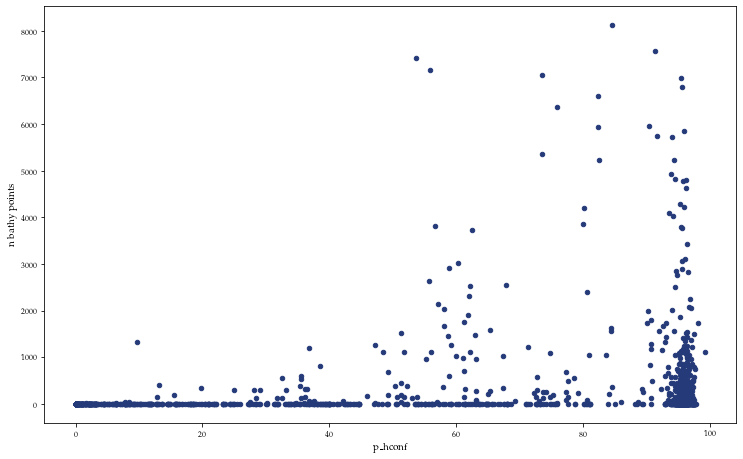

In [56]:
final_trackline_summary.plot.scatter(y='n bathy points',x='p_hconf',figsize=set_size(fraction=2))

<AxesSubplot:xlabel='avg_fsat', ylabel='n bathy points'>

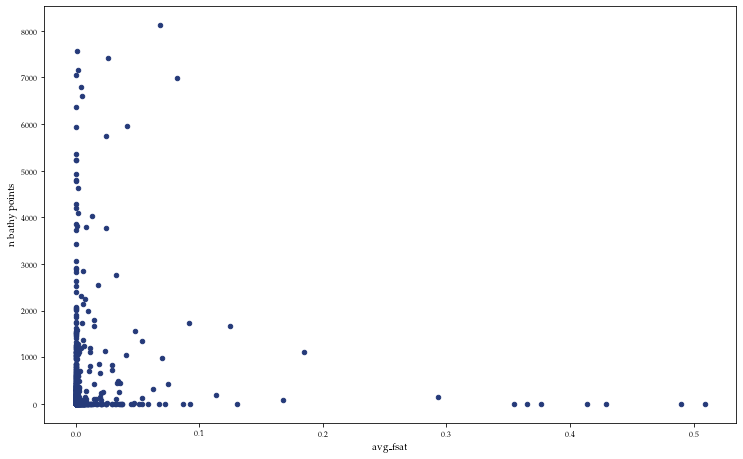

In [67]:
final_trackline_summary.plot.scatter(y='n bathy points',x='avg_fsat',figsize=set_size(fraction=2))

<AxesSubplot:xlabel='p_hconf', ylabel='RMS Error [m]'>

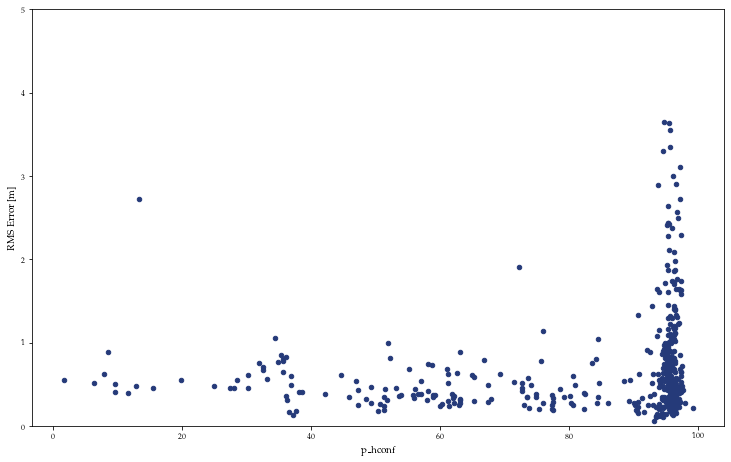

In [65]:
final_trackline_summary.plot.scatter(y='RMS Error [m]',x='p_hconf',figsize=set_size(fraction=2),ylim=(0,5))

<AxesSubplot:xlabel='avg_fsat', ylabel='RMS Error [m]'>

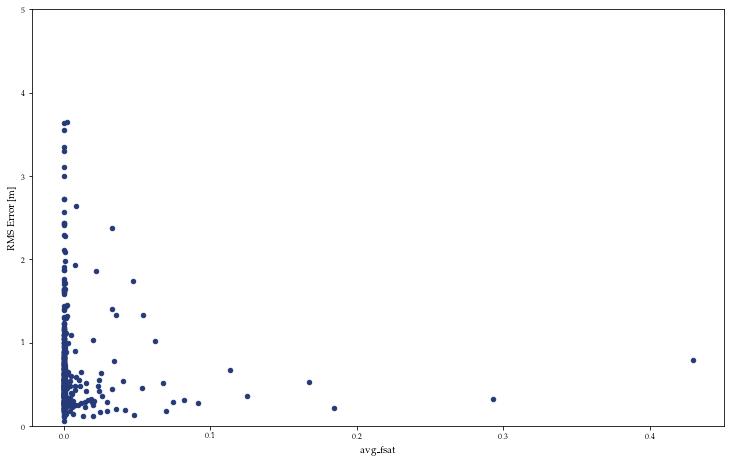

In [68]:
final_trackline_summary.plot.scatter(y='RMS Error [m]',x='avg_fsat',figsize=set_size(fraction=2),ylim=(0,5))

<AxesSubplot:xlabel='ph_per_m', ylabel='RMS Error [m]'>

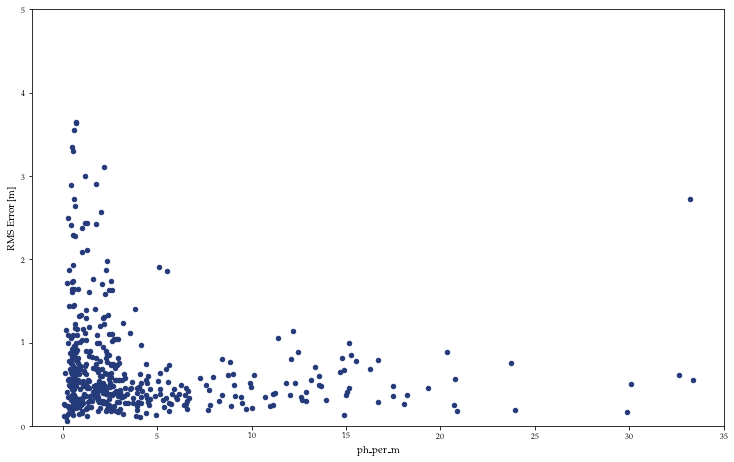

In [69]:
final_trackline_summary.plot.scatter(y='RMS Error [m]',x='ph_per_m',figsize=set_size(fraction=2),ylim=(0,5))

In [72]:
final_trackline_summary.corr()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n_photons,1.000000,-0.455528,0.750564,0.035475,0.208414,-0.025641,-0.020156,0.028433,-0.010364,0.789318
p_hconf,-0.455528,1.000000,-0.562832,0.045582,0.112892,-0.145115,-0.152772,-0.205940,0.189989,-0.561887
avg_ph_cou,0.750564,-0.562832,1.000000,-0.026718,-0.127449,0.071554,0.076762,0.116769,-0.102190,0.942948
avg_fsat,0.035475,0.045582,-0.026718,1.000000,0.129803,-0.018168,-0.015814,-0.002377,0.039296,-0.022024
length,0.208414,0.112892,-0.127449,0.129803,1.000000,-0.094507,-0.095884,-0.044410,0.282185,-0.148918
RMS Error [m],-0.025641,-0.145115,0.071554,-0.018168,-0.094507,1.000000,0.999446,0.861760,-0.062538,0.039141
MAE [m],-0.020156,-0.152772,0.076762,-0.015814,-0.095884,0.999446,1.000000,0.863454,-0.058459,0.044837
Mean Error [M],0.028433,-0.205940,0.116769,-0.002377,-0.044410,0.861760,0.863454,1.000000,-0.008822,0.090072
n bathy points,-0.010364,0.189989,-0.102190,0.039296,0.282185,-0.062538,-0.058459,-0.008822,1.000000,-0.090531
ph_per_m,0.789318,-0.561887,0.942948,-0.022024,-0.148918,0.039141,0.044837,0.090072,-0.090531,1.000000


In [73]:
final_trackline_summary.cov()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,ph_per_m
n_photons,1.093197e+10,-1.868454e+06,3.082510e+07,124.332674,1.279190e+08,-10353.024953,-8075.239251,11505.293866,-9.884864e+05,993269.647032
p_hconf,-1.868454e+06,1.538991e+03,-8.672896e+03,0.061038,2.599806e+04,-17.558983,-18.341854,-24.973066,6.798771e+03,-265.297600
avg_ph_cou,3.082510e+07,-8.672896e+03,1.542890e+05,-0.359036,-2.938741e+05,78.871936,83.955474,128.992035,-3.661513e+04,4457.805274
avg_fsat,1.243327e+02,6.103831e-02,-3.590363e-01,0.001169,2.594490e+01,-0.003121,-0.002696,-0.000409,1.199029e+00,-0.008876
length,1.279190e+08,2.599806e+04,-2.938741e+05,25.944904,3.446022e+07,-2984.651107,-3004.604965,-1405.574731,1.511042e+06,-10521.402798
RMS Error [m],-1.035302e+04,-1.755898e+01,7.887194e+01,-0.003121,-2.984651e+03,31.102225,30.843560,26.860990,-4.887200e+02,1.145666
MAE [m],-8.075239e+03,-1.834185e+01,8.395547e+01,-0.002696,-3.004605e+03,30.843560,30.620951,26.704740,-4.532959e+02,1.302212
Mean Error [M],1.150529e+04,-2.497307e+01,1.289920e+02,-0.000409,-1.405575e+03,26.860990,26.704740,31.237728,-6.909130e+01,2.642175
n bathy points,-9.884864e+05,6.798771e+03,-3.661513e+04,1.199029,1.511042e+06,-488.720004,-453.295942,-69.091304,8.320818e+05,-993.911772
ph_per_m,9.932696e+05,-2.652976e+02,4.457805e+03,-0.008876,-1.052140e+04,1.145666,1.302212,2.642175,-9.939118e+02,144.854546


In [76]:
final_trackline_summary.columns

Index(['file', 'beam', 'rgt', 'date', 'beam_type', 'n_photons', 'p_hconf',
       'avg_ph_cou', 'avg_fsat', 'length', 'geometry', 'site', 'RMS Error [m]',
       'MAE [m]', 'Mean Error [M]', 'n bathy points', 'ph_per_m'],
      dtype='object')

In [185]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,TruncatedSVD

In [120]:
final_trackline_summary.count()

file              1415
beam              1415
rgt               1415
date              1415
beam_type         1415
n_photons         1415
p_hconf           1415
avg_ph_cou        1415
avg_fsat          1313
length            1415
geometry          1415
site              1415
RMS Error [m]      485
MAE [m]            485
Mean Error [M]     485
n bathy points    1415
ph_per_m          1415
dtype: int64

In [127]:
# get the dependant variables and standardize them from 0-1
x = final_trackline_summary.loc[:,['n_photons', 'p_hconf','avg_ph_cou','length', 'n bathy points', 'ph_per_m']].to_numpy()
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = final_trackline_summary.loc[:,'n bathy points'].to_numpy()<=5

pcs = PCA(n_components=2,).fit_transform(x)

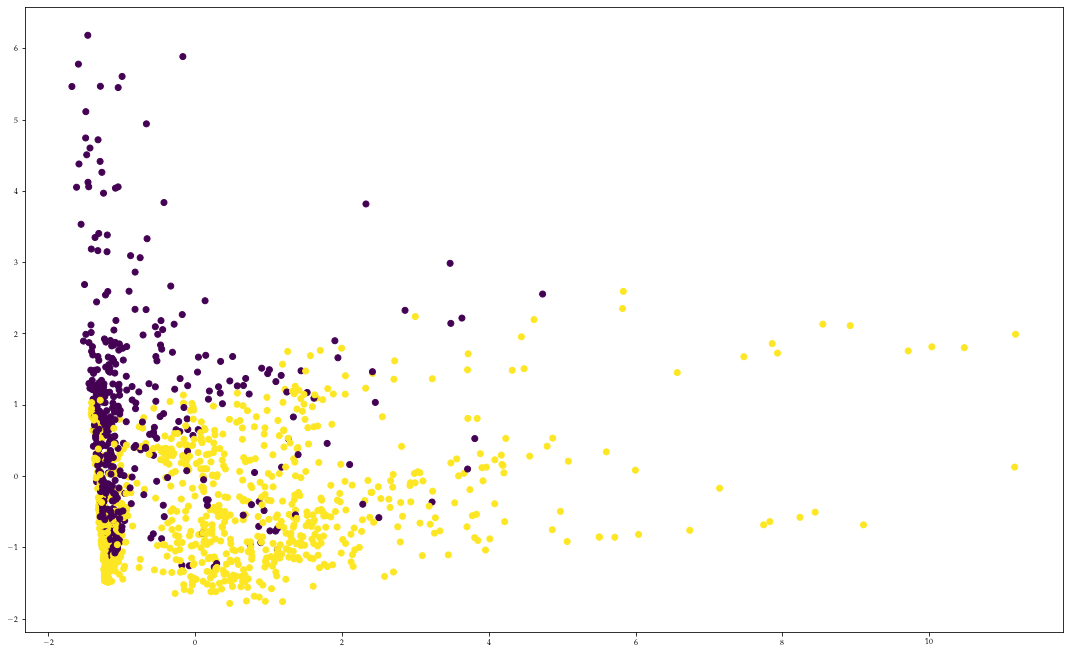

In [128]:
fig,ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:,0],pcs[:,1],c=y)

# PCA for each point to identify error

In [193]:
columns_of_interest = ['ph_count','gebco_elev',
       'sea_level_interp', 'sea_level_std_dev','kde_val', 'beamtype',
       'oc_hconf_perc', 'n_subsurf_points', 'n_total_points']

x = bathy_pts_df.assign(beamtype=(bathy_pts_df.beamtype == 'weak').astype('int')).loc[:,columns_of_interest].to_numpy()
x = StandardScaler().fit_transform(x)

# get the dependant variable
y = bathy_pts_df.loc[:,'error_abs'].to_numpy()

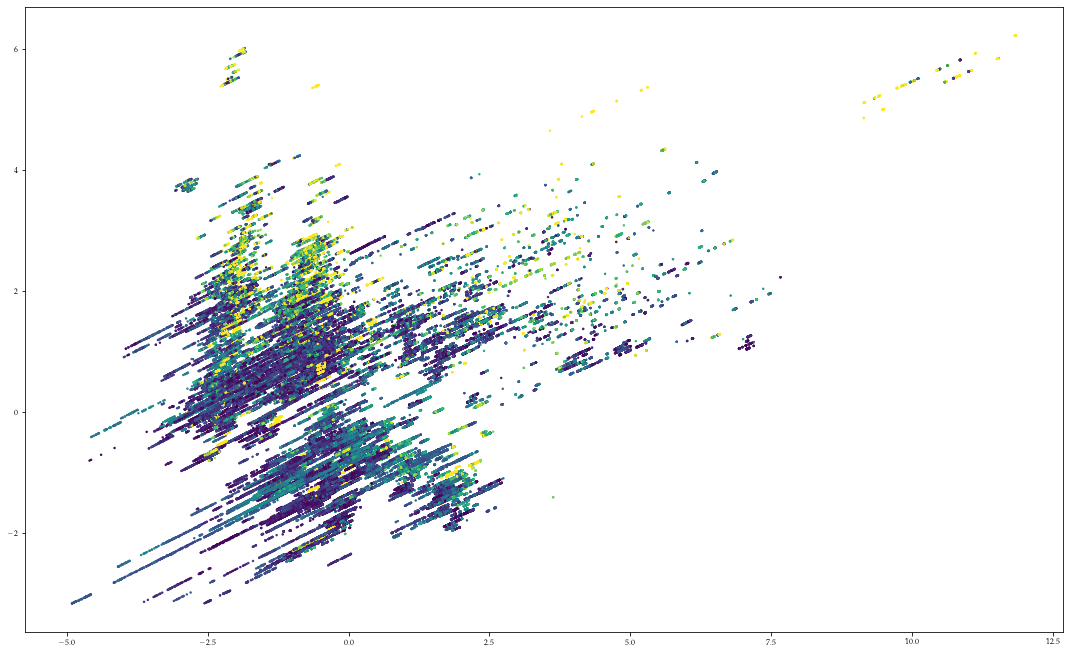

In [194]:
pcs = TruncatedSVD(n_components=2).fit_transform(x)

fig,ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs[:,0],pcs[:,1],c=y,s=2,vmax=1)

(0.0, 1.0)

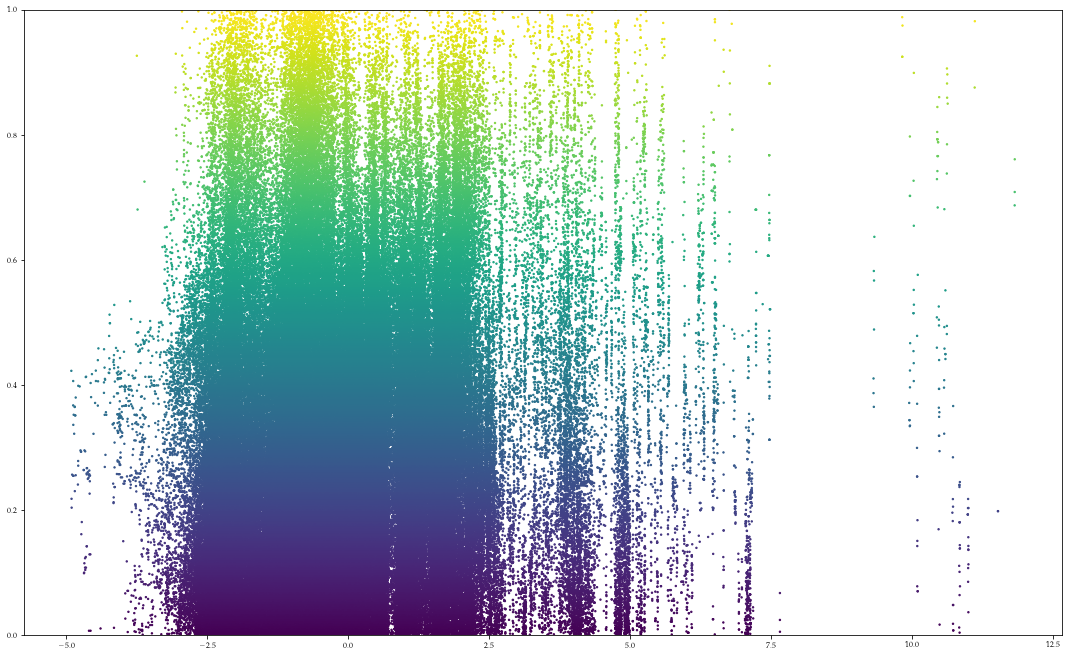

In [195]:
pcs = TruncatedSVD(n_components=1).fit_transform(x)

fig,ax = plt.subplots(figsize=set_size(fraction=3))

ax.scatter(pcs,y,c=y,s=2,vmax=1)
ax.set_ylim(0,1)

# Bias plot of all sites

ValueError: cannot combine transform and aggregation operations

In [ ]:
error_lidar_pt_vs_truth_pt(bathy_pts_df,'All Sites',